<h1 style="text-align: center; ">Проект №3</h1>

<h3 style="text-align: center; ">Выполнили: Ануров, Алешин, Бердышев, Сулейманов</h3>

In [1]:
import numpy as np
import pandas as pd
import json
import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mean_absolute_error as mae, mean_squared_log_error as msle, make_scorer
tqdm.tqdm.pandas()
from dateutil.relativedelta import *
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('error')

In [2]:
start_date = '2017-01-09'
end_date = '2021-03-31'

# Модуль определения аномалий

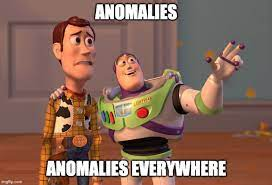

In [3]:
class AnomalyDetector(object):
    """
    Класс для детектирования аномалий методом CUSUM

    Параметры
    ----------
    backward_window_size : integer, optional, default 30
        Размер временного окна для оценки статистик
    
    forward_window_size : integer, optional, default 14
        Размер временнего окна для сравнения с backward_window_size

    threshold : float, optional, default 5.0
        Порог

    drift : float, optional, default 1.0
        Отклонение от среднего

    anomalies: pd.Series
        последовательность нулей и единиц(с сохранением последовательности индексов изначально временного ряда), 1 - аномалия, 0 - не аномалия
    
    """

    def __init__(self, backward_window_size=30, forward_window_size=14, 
                 threshold=5.0, drift=1.0):
        self.backward_window_size = backward_window_size
        self.forward_window_size = forward_window_size
        self.threshold = threshold
        self.drift = drift
        self.anomalies_ = None


    def one_pass(self, train_zone, prediction_zone, threshold=None, drift=None):
        """
        Функция для обнаружения аномалий за один проход

        Параметры
        ----------
        train_zone : pandas.Series or pandas.DataFrame
            Обучающая выборка для подсчета нужных статистик

        prediction_zone : pandas.Series or pandas.DataFrame
            Тестовая выборка для обнаружения аномалий

        threshold : float, optional, default 5.0
            Порог

        drift : float, optional, default 1.0
            Смещение

        Возвращает
        -------
        is_fault : numpy array
            Является аномалией или нет
        """

        if not threshold:
            threshold = self.threshold
        if not drift:
            drift = self.drift

        current_std = np.nanstd(train_zone, ddof=1)
        current_mean = np.nanmean(train_zone)
        drift = drift * current_std
        threshold = threshold * current_std

        x = prediction_zone.astype('float64')
        gp, gn = np.zeros(x.size), np.zeros(x.size)

        for i in range(1, x.size):
            gp[i] = max(gp[i-1] + x[i] - current_mean - drift, 0)
            gn[i] = min(gn[i-1] + x[i] - current_mean + drift, 0)

        is_fault = np.logical_or(gp > threshold, gn < -threshold)
        return is_fault

    def detect(self, time_series, threshold=None, drift=None, excluded_points=None):
        """
        Функция для обнаружения аномалий в скользящем окне

        Параметры
        ----------
        time_series : pandas.Series
            Временной ряд

        threshold : float, optional, default 5.0
            Порог

        drift : float, optional, default 1.0
            Смещение

        excluded_points : pandas.Series.index
            Точки, которые будем исключать

        Возвращает
        -------
        self.anomalies_ : pandas.Series, shape = [len(time_series)]
            последовательность нулей и единиц, 1 - аномалия, 0 - не аномалия

        """
        if excluded_points is not None:
            time_series[time_series.index.isin(excluded_points)] = np.nan

        ts_values = time_series.values
        ts_index = time_series.index

        detection_series = np.zeros(len(ts_values)).astype('int32')

        for ini_index in range(len(ts_values) - (self.backward_window_size + self.forward_window_size)):
            sep_index = ini_index + self.backward_window_size
            end_index = sep_index + self.forward_window_size
            faults_indexes = self.one_pass(ts_values[ini_index:sep_index],
                                           ts_values[sep_index:end_index],
                                           threshold, drift)
            detection_series[sep_index:end_index][faults_indexes] = 1
        self.anomalies_ = pd.Series(detection_series, index=ts_index)

        return self.anomalies_

# Модуль генерации признаков
## Использованы:
- временной ряд
- курс доллара
- календарные признаки (выходные, праздники, последние дни года, дни недели, месяцы)
- скользащие статистики по дням, неделям, месяцу
- лаги

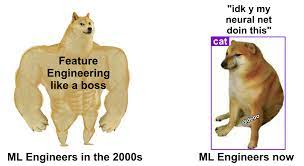

In [4]:
def make_features(time_series,
                  calendar_features=None,
                  is_mean_month=True,
                  window_weekdays=3, 
                  window_days=7, 
                  lags=range(1, 5),
                  usd_course_feature=None):
    """
    Модуль для генерации признаков

    Параметры
    ----------
    time_series : pandas.Series
        Временной ряд
    calendar_features : pandas.DataFrame
        Набор календарных фичей
        
    is_mean_month : bool, default True
        Считаем ли среднее по месяцу
    
    window_weekdays : integer, default 3
        Размер недельного временнего окна
    
    window_days : integer, default 7
        Размер дневного временнего окна
    
    lags : range, default (1, 5)
        Размер лагов

    usd_course_feature : pandas.Series
        Курс рубль-доллар
    
    Возвращает
    -------
    data: pd.DataFrame
        Датафрейм с признаками
    """
    data = pd.DataFrame(time_series).copy()
    data.columns = ['y']


    # лаги
    if lags is not None:
        for i in lags:
            data['lag_{}'.format(i)] = data.y.shift(i)
        m_lag_1 = []
        m_lag0 = []
        m_lag1 = []
        for i in range(data.shape[0]):
            date_1 = data.iloc[i].name - relativedelta(months=1) - relativedelta(days=1)
            if date_1 in data.index:
                m_lag_1.append(data.loc[date_1, 'y'])
            else:
                m_lag_1.append(np.nan)

            date0 = data.iloc[i].name - relativedelta(months=1)
            if date0 in data.index:
                m_lag0.append(data.loc[date0, 'y'])
            else:
                m_lag0.append(np.nan)

            date1 = data.iloc[i].name - relativedelta(months=1) + relativedelta(days=1)
            if date1 in data.index:
                m_lag1.append(data.loc[date1, 'y'])
            else:
                m_lag1.append(np.nan)
        data['lag_month_1'] = m_lag_1
        data['lag_month0'] = m_lag0
        data['lag_month1'] = m_lag1

    # скользящие статистики по дням
    if window_days is not None:
        for stat_type in ['mean', 'median', 'max', 'min', 'std']:
            data['rolling_' + stat_type] = getattr(pd.Series.rolling(data['y'], window_days), stat_type)().shift(1)

    # скользящие статистики по неделям
    if window_weekdays is not None:
        for stat_type in ['mean', 'median', 'max', 'min', 'std']:
            data_group = data['y'].groupby(data.index.weekday)
            data['rolling_' + stat_type + '_weekday'] = data_group.transform\
                        (lambda x: getattr(pd.Series.rolling(x, window_weekdays), stat_type)().shift(1))

    # скользящие статистики по месяцу
    if is_mean_month is not None:
        for stat_type in ['mean', 'median', 'max', 'min']:#, 'std']:
            data_group = data['y'].groupby(data['y'].index.month)
            if stat_type != 'std':
                data_stat = data_group.transform(lambda x: getattr(np, 'nan' + stat_type)(x)).copy()
            else:
                data_stat = data_group.transform(lambda x: getattr(np, 'nan' + stat_type)(x, ddof=1)).copy()
            data[stat_type + '_month'] = list(map(dict(zip(data_stat.index.month, data_stat)).get, data.index.month))

    # доп фичи
    if calendar_features is not None:
        data = pd.concat([data, calendar_features], axis=1, join='inner')
        
    if usd_course_feature is not None:
        data = pd.concat([data, usd_course_feature], axis=1, join='inner')
    return data

In [5]:
import pandas as pd
import datetime
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay

open_data_calendar = pd.read_csv('./calendar.csv')
holiday_list = []

for i in range(open_data_calendar.shape[0]):
    row = open_data_calendar.iloc[i]
    
    year = int(open_data_calendar.iloc[i]['Год/Месяц'])
    for i_month, month_name in enumerate(open_data_calendar.columns[1:13]):
        month = i_month + 1
        for day_str in row[month_name].split(','):
            if day_str[-1] != '*':
                if day_str[-1] == '+':
                    day_str = day_str[:-1]
                day = int(day_str)
                holiday_list.append(datetime.datetime(year, month, day))
                
holiday_df = pd.DataFrame(holiday_list, columns=['holidays'])                
holiday_df.index = pd.to_datetime(holiday_list)
holiday_df = holiday_df.sort_index()
holiday_df.to_csv('./holidays_df.csv', index=False)
                
class RussianBusinessCalendar(AbstractHolidayCalendar):
    start_date = datetime.datetime(1999, 1, 1)
    end_date = datetime.datetime(2022, 12, 31)
    rules = [
        Holiday(name='Russian Day Off', year=d.year, month=d.month, day=d.day)
        for d in pd.to_datetime(holiday_df['holidays'])
    ]
    
russian_busday = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri Sat Sun', calendar=RussianBusinessCalendar())


# Формирование календарных признаков

events = pd.DataFrame(index=pd.date_range(start_date, end_date))
events = pd.merge(events, holiday_df, how='left', left_index=True, right_index=True).fillna('Work')
events.index = pd.to_datetime(events.index)

# выходной
events.loc[events.holidays != 'Work', 'holidays'] = 1
events.loc[events.holidays == 'Work', 'holidays'] = 0
events.rename(columns={'holidays':'выходной'}, inplace=True)

# праздник
events['праздник'] = [0 for _ in range(events.shape[0])]
events.loc[(events.index.day.isin([1, 2, 3, 4, 5, 6, 7, 8]))  
               & (events.index.month == 1), 'праздник'] = 1 # новогодние
events.loc[(events.index.day == 23) & (events.index.month == 2), 'праздник'] = 1 # 23 февраля
events.loc[(events.index.day == 8) & (events.index.month == 3), 'праздник'] = 1 # 8 марта
events.loc[(events.index.day == 1) & (events.index.month == 5), 'праздник'] = 1 # 1 мая
events.loc[(events.index.day == 9) & (events.index.month == 5), 'праздник'] = 1 # 9 мая
events.loc[(events.index.day == 12) & (events.index.month == 6), 'праздник'] = 1 # День России
events.loc[(events.index.day == 4) & (events.index.month == 11), 'праздник'] = 1 # День народного единства

# предпраздничный рабочий день
holidays = events[events['праздник'] == 1].index
inds = [datetime.datetime(day.year, day.month, day.day) + pd.Timedelta(days=1) - russian_busday for day in holidays]
events['предпраздничный рабочий день'] = [0 for _ in range(events.shape[0])]
events.loc[events.index.isin(inds), 'предпраздничный рабочий день'] = 1

# первый день после праздника
inds = [datetime.datetime(day.year, day.month, day.day) + pd.Timedelta(days=1) + russian_busday for day in holidays]
events['послепраздничный рабочий день'] = [0 for _ in range(events.shape[0])]
events.loc[events.index.isin(inds), 'послепраздничный рабочий день'] = 1

# последний день и последний рабочий день месяца
month_lastdays = [pd.to_datetime(str(year)) + pd.offsets.MonthEnd(i) for year in events.index.year.unique()
                  for i in range(1, 13)]
events['последний день месяца'] = [0 for _ in range(events.shape[0])]
events.loc[events.index.isin(month_lastdays), 'последний день месяца'] = 1

inds = [datetime.datetime(day.year, day.month, day.day) + pd.Timedelta(days=1) - russian_busday for day in month_lastdays]
events['последний рабочий день месяца'] = [0 for _ in range(events.shape[0])]
events.loc[events.index.isin(inds), 'последний рабочий день месяца'] = 1

# дни недели
for i, name in enumerate(['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']):
    events[name] = [1 if day == i else 0 for day in events.index.weekday]
    
# месяцы
for i, name in enumerate(['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 
                          'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']):
    events[name] = [1 if month == i + 1 else 0 for month in events.index.month]
    
# Последние 5 дней в году
for i, name in enumerate(['27-Дек', '28-Дек', '29-Дек', '30-Дек', '31-Дек']):
    events['конец года'] = [1 if (month == 12) and (day == 27 + i) else 0
                            for month in zip(events.index.month, events.index.day)]
    
events.to_csv('./calendar_features.csv')

# Модуль подбора гиперапарметров и наша асимметричная кастомная метрика

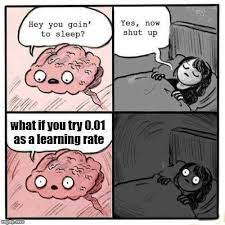

In [6]:
def custom_metric(y_true, y_pred):
     '''
     Данная асимметричная метрика сделана, чтобы учесть потребности бизнеса - недопрогноз хуже, чем перепрогноз.
     Поэтому в случае недопрогоноза штраф в 2 раза больше, чем при перепрогнозе. 
     '''
     residual = (y_true - y_pred).astype("float")
     loss = np.where(residual < 0, abs(residual)*2.0, abs(residual))
     return np.mean(loss)

our_metric = make_scorer(custom_metric) 

def find_params(curr_data):
    '''
    Модуль для подбора гиперпараметров 
    В качестве модели используем случайный лес
    '''
    test_num = 90  
    X = curr_data.drop('y', axis=1)
    y = curr_data['y']
    model = RandomForestRegressor()

    # Создаем список, где тренировочные индексы помечена -1, а валидационные 0
    split_index = [-1] * (X.shape[0] - test_num) + [0] * test_num

    pds = PredefinedSplit(test_fold = split_index)

    # описание сетки гиперпараметров
    param_grid = {
        'max_depth' : [2, 3, 5, 7, 9, 11, 13],
        'max_features' : [0.5, 0.6, 0.7, 0.8],
        'max_samples' : [None, 0.5, 0.6, 0.7, 0.8],
        'min_samples_split' : [2, 5, 7],
        'min_samples_leaf' : [1, 2, 4, 6],
        'n_estimators' : [150],
        'criterion' : ['absolute_error'],
        'random_state' : [4],
        'n_jobs' : [1]

    }

    clf = RandomizedSearchCV(estimator = model,
                             cv=pds,
                             param_distributions=param_grid,
                             n_jobs=-1,
                             refit=False,
                             n_iter=100,
                             scoring=our_metric,
                             verbose=0)
    search = clf.fit(X, y)
    return search.best_params_

# Модуль отбора признаков

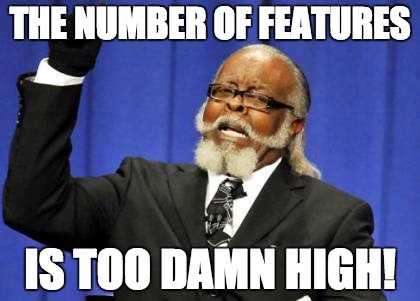

## Оберточный метод

Forward selection

In [7]:
def best_feature(model, X, y, features_in, features_out):
    lag = 40
    X_train, y_train = X.iloc[:-lag] , y.iloc[:-lag]
    X_test, y_test = X.iloc[-lag:] , y.iloc[-lag:]
    model.fit(X_train[features_in], y_train)
    metric_baseline = mae(y_test, model.predict(X_test[features_in]))
    feature_to_add = None
    for name in features_out:
        model.fit(X_train[features_in + [name]], y_train)
        metric_new = mae(y_test, model.predict(X_test[features_in + [name]]))
        if metric_new > metric_baseline:
            feature_to_add = name
            metric_baseline = metric_new
    return feature_to_add

In [8]:
def find_best_feature_space(model, X, y):
    features_importance = dict(zip(X.columns, model.feature_importances_))
    top_10_features = []
    for _ in range(10):
        max_key = max(features_importance, key=features_importance.get)
        features_importance[max_key] = .0
        top_10_features.append(max_key)
    features_to_select = list(set(X.columns) - set(top_10_features))
    while True:
        add = best_feature(model, X, y, top_10_features, features_to_select)
        if add == None:
            break
        else:
            top_10_features+= [add]
    return top_10_features

## Встроенный метод

Прогоняем линейную регрессию, выбираем топ самых влиятельных фичей

In [9]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def linear_feature_selection(X, y):
    feature_standartization = [None if len(X[x_name].unique()) == 2 else x_name for x_name in X.columns]
    feature_standartization = list(filter(None , feature_standartization))
    ssc = StandardScaler()
    X[feature_standartization] = ssc.fit_transform(X[feature_standartization])
    regressor = Ridge()
    regressor.fit(X, y)
    feature_selection = dict(zip(X.columns, [abs(number) for number in regressor.coef_]))
    top_features = []
    for _ in range(15):
        max_key = max(feature_selection, key=feature_selection.get)
        feature_selection[max_key] = .0
        top_features.append(max_key)
    return  top_features


## Фильтрационный метод

Выбор по корреляции между фичей и таргетом

In [10]:
def filter_feature_selection(X, y):
    return list(X.corrwith(y).sort_values(ascending=False).head(15).index)

## Метрика стабильности

В качестве метрики стабильности между i и j набором фичей будет рассматриваться мера схожести как евклидово расстояние (есть фича- (1 - 1), фича пропала - (1 - 0), за все итеррации будет браться среднее)

In [11]:
def euclidean_distance(feature_i, feature_j):
    n = 0
    for feature in feature_j:
        if feature in feature_i:
            n+=1
    return np.sqrt(n)

# Считываем данные

In [12]:
df = pd.read_excel('./Project 2_2022.xlsx', index_col=0, parse_dates=True)

In [13]:
calendar_features = pd.read_csv('./calendar_features.csv', index_col=0, parse_dates=True)

In [14]:
ts = df['Balance'].to_frame()#.T.reset_index(drop=True)

In [15]:
usd_course = pd.read_csv('./usd_rub_course.csv', index_col=0, 
                 parse_dates=True).resample('1D').sum()['Close']\
                    .shift(1).dropna().to_frame()
usd_course.columns = ['usd_rub_course']
usd_course

## Наш временной ряд

In [16]:
from matplotlib import pyplot as plt
plt.figure(figsize=(17, 4))
plt.plot(ts['Balance'])
plt.grid()
plt.show()

# Прогон модели

## Фит и рефит модели
- частота рефита должна быть небольшой, т.к. деревянные модели
- не могут улавливать тренд
- поэтому выбрали частоту обучения раз в 2 недели, в случае обнаружении аномалий модель начнет рефит раньше

In [17]:
from datetime import timedelta
from tqdm import tqdm

param_resel_freq = 14
refit_freq = 14
last_refit_date = pd.to_datetime('2000-01-01')
last_param_resel_date = pd.to_datetime('2000-01-01')
preds = []


daterange = pd.date_range('2020-01-01', '2020-01-20')
for curr_date in tqdm(daterange):
    detector = AnomalyDetector(backward_window_size=30, forward_window_size=14, 
                               threshold=3, drift=1.1)
    
    # если за последнюю неделю 6 или более аномалий, то разладка
    anomalies = detector.detect(ts.loc[:curr_date, 'Balance'])
    if anomalies.iloc[-7:].sum() >= 6:
        print(f'ЗАДЕТЕКТИРОВАНА РАЗЛАДКА:')
        plt.figure(figsize=(14, 4))
        plt.plot(ts.loc[:curr_date, 'Balance'])
        tmp_anoms = anomalies.replace(0, np.nan).dropna()
        plt.scatter(tmp_anoms.index, ts.loc[tmp_anoms.index, 'Balance'], 
                    color='red')
        plt.grid()
        plt.show()

    data = make_features(calendar_features=calendar_features,
                         time_series=ts.loc[:curr_date+timedelta(days=1), 
                                            'Balance'],
                        usd_course_feature=usd_course).dropna()
    #break
    if (curr_date - last_param_resel_date).days >= param_resel_freq or \
            anomalies.iloc[-7:].sum() >= 6:
        params = find_params(data.loc[:curr_date])
        last_param_resel_date = curr_date
        
    if (curr_date - last_refit_date).days >= refit_freq or \
            anomalies.iloc[-7:].sum() >= 6:
        model = RandomForestRegressor(**params)
        model.fit(data.loc[:curr_date].drop('y', axis=1), data.loc[:curr_date, 'y'])
        last_refit_date = curr_date
    preds.append(model.predict(data.iloc[-1:].drop('y', axis=1)))

In [18]:
preds = np.asarray([i[0] for i in preds])

In [19]:
y_true = ts.loc[daterange, 'Balance'].values

In [26]:
mae(y_true, preds)

0.1566538048599398

# ошибка меньше чем заданная граница 0.42

In [27]:
find_best_feature_space(model, data.loc[:curr_date].drop('y', axis=1), data.loc[:curr_date, 'y'])

['lag_1',
 'lag_2',
 'lag_month0',
 'lag_4',
 'lag_month_1',
 'rolling_median',
 'lag_3',
 'rolling_min',
 'lag_month1',
 'rolling_max',
 'август']

In [28]:
filter_feature_selection(data.loc[:curr_date].drop('y', axis=1), data.loc[:curr_date, 'y'])

['rolling_median_weekday',
 'rolling_mean_weekday',
 'rolling_median',
 'rolling_min_weekday',
 'usd_rub_course',
 'rolling_mean',
 'rolling_max_weekday',
 'чт',
 'mean_month',
 'lag_1',
 'rolling_min',
 'lag_2',
 'сентябрь',
 'min_month',
 'max_month']

In [29]:
linear_feature_selection(data.loc[:curr_date].drop('y', axis=1), data.loc[:curr_date, 'y'])

['rolling_std',
 'rolling_min',
 'пн',
 'послепраздничный рабочий день',
 'чт',
 'выходной',
 'rolling_mean',
 'rolling_max',
 'предпраздничный рабочий день',
 'последний день месяца',
 'сб',
 'вс',
 'последний рабочий день месяца',
 'rolling_max_weekday',
 'usd_rub_course']

Средние изменения евклидового расстояния по фичам:   
   - Фильтрационный - 0.35
   - Встроенные - 3.2
   - Оберточные - 1.2  
Самую высокую стабильность показали фильтрационные методы, однако у них худшие значения по mae, мы выбрали оберточные.